Use nbdev to create a python file that can be imported to the other notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#WHERE DOES PYTHON LOOK FOR THINGS?  THIS IS THE SEARCH PATH
#import sys
#sys.path
!hostname

spearhead


In [3]:
#export
#fastai2 imports
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.data.all import *
from fastai2.vision.all import *
from fastai2.metrics import accuracy_multi
from torch.autograd import Variable
#Other imports
import pdb
from IPython.core.debugger import set_trace
import datetime
import json
import glob
import image_bbox_slicer as ibs

#These are all included in fastai:
#from pathlib import Path
#import numpy as np
#import pandas as pd

#Imports from fastaiV1
#from fastai.script import *
#from fastai.distributed import *
#torch.backends.cudnn.benchmark = True
#import time
# from fastai.callbacks.tracker import *
# from fastai.callbacks import *
# import logging
#torch.backends.cudnn.benchmark = True
#import time

In [4]:
def classdict(cls):
    return dict((key, value) for (key, value) in cls.__dict__.items())

Check how many loggers you have running (can be waaaay too many!)
```python
if not logging.Logger.manager.loggerDict is None:
    {print(key,value) for key,value in list(logging.Logger.manager.loggerDict.items())}
```

In [ ]:
# #NOT USED WHILE DEVELOPING
# #LOGGERS DON'T DIE, so print() statements are easier to deal with while developing.  Logging is nice later.

# #We start by killing any existing handlers off; otherwise they propagate
# if hasattr(log,'handlers'):
#     handlers = log.handlers[:]
#     for handler in handlers:
#         handler.close()
#         log.removeHandler(handler)

# #Set up logging
# log = logging.getLogger()
# log.setLevel(logging.INFO)
# #log.propagate = False
# formatter = logging.Formatter('%(asctime)s - %(message)s')

# #create file handler which logs warnings and up
# #fh = logging.FileHandler('training_log')
# #fh.setLevel(logging.INFO)
# #fh.setFormatter(formatter)
# #log.addHandler(fh)

# #create console handler with a higher log level
# ch = logging.StreamHandler()
# ch.setLevel(logging.INFO)
# ch.setFormatter(formatter)
# log.addHandler(ch)


In [19]:
#coco_source = untar_data(URLs.COCO_TINY) #returns a Path

## Get files onto the VM

Howard's files were on AWS.  He gave me access to the folder.  See "AWS" note in Evernote for details.
- I installed AWS CLI on Azure VM 
- I created an AWS profile on VM 
- I used the CLI to pull files onto /cdata (for the first round, I only transferred the folder TA25).  
```bash 
# From VM
cd /cdata/tanzania/TA25 #check dir before updating!
aws s3 --profile aisurvey sync s3://aisurvey/TA25/ .
```

### Set the filepath for the images

In [5]:
imagepath = Path('/cdata/tanzania/TA25')
imagepath

Path('/cdata/tanzania/TA25')

In [6]:
annotationpath = Path('/cdata/tanzania/TA25')
annotationpath

Path('/cdata/tanzania/TA25')

### Read in the metadata (filenames)

In [9]:
#Get Pascal-VOC annotation files (in /TA25 itself)
annotation_files = [str(x) for x in annotationpath.iterdir() if str(x).find('pascal') > 0 and x.suffix == '.zip'] #convert strings to Paths and get parent folder
annotation_files

['/cdata/tanzania/TA25/TA25-RKE-20191128A_pascalvoc.zip',
 '/cdata/tanzania/TA25/TA25-RKE-20191202-3_pascalvoc.zip']

In [ ]:
PASCAL-VOC annotation files are usually in a zip file that contains one .xlm annotation file per image. 
- Images that were checked but had no objects of interest in them do not appear in the annotation files
- There is no image path information in the xml files at present 



### Fun with annotations
- There are multiple annotation files; here we use PASCAL-VOC format.
<!--     COCO-JSON
    - Each annotation file corresponds to a different 'annotation file root' (AFR) directory. The AFR is named by date. 
    - Each AFR may include subdirectories indicated by appending 'A', 'B', etc. to the AFR name
    - Each annotation file's JSON includes the date under the "info"/"description" keys, and 
    - Each annotation file contains annotations for some, but not all, images in sub-directories of the parent directory.  -->
    
PASCAL-VOC annotation files are usually in a zip file that contains one .xlm annotation file per image. 
- Images that were checked but had no objects of interest in them do not appear in the annotation files
- There is no image path information in the xml files at present 

So my strategy is to process each annotation file separately, converting the complicated JSON annotation format into the simpler fastai format, and then add empty annotations for the missing files:
- For each annotation file, f
    1. Make a list ('annotated_images') of files in f, taken directly from the annotation
    2. Convert the annotations from f into fastai format
    3. Get the date from the annotation file JSON, and find directories (Ds) containing that date
    4. Walk the directories (Ds + subdirectories) and make a list (L_tot) of all files
    5. Compare L_ann and L_tot, and list the empty files (L_empty)
    6. Create empty annotations `[[[0., 0., 0., 0.]],[]]` for each filename in L_empty
    7. Finally, append the empty files and empty annotations to the files in annotations in L_ann



In [42]:
#Step 1 & 2
fnames, lbl_bbox = get_annotations(annotationpath/'TA25-RKE-20191201_coco.json')
annotated_images = [str(imagepath/k) for k in fnames]
len(annotated_images),annotated_images[:5]

(85,
 ['/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_L/TA25-RKE-20191201A_L_4818.jpg',
  '/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_L/TA25-RKE-20191201A_L_4820.jpg',
  '/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_L/TA25-RKE-20191201A_L_4821.jpg',
  '/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201B/TA25-RKE-20191201B_L/TA25-RKE-20191201B_L_4885.jpg',
  '/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_L/TA25-RKE-20191201A_L_4823.jpg'])

In [43]:
#Step 3.  Get the date from the annotation file JSON, and find folders containing that date
ann = json.load(annotationpath/'TA25-RKE-20191201_coco.json')
ann_target = str(ann['info']['description'] + '*') #Add the star for the glob search in the next step
ann_target_folders = [ x for x in Path('/cdata/tanzania/TA25/_data/RKE/').glob(ann_target)]
ann_target_folders

[Path('/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201A'),
 Path('/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201B')]

In [44]:
#Step 4
#This step is complicated by the fact that we may have multiple parent folders to search
tot_images = []

for d in range(0,len(ann_target_folders)):
    imgs = None
    imgs = get_image_files(ann_target_folders[d])
    imgs = [str(im) for im in imgs]
    print(str(ann_target_folders[d]),len(imgs),'image files')
    tot_images = tot_images + imgs #Join lists
    
print('Total images: ',len(tot_images))

/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201A 109 image files
/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201B 23 image files
Total images:  132


In [45]:
tot_images[:5]

['/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_R/TA25-RKE-20191201A_R_4120.jpg',
 '/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_R/TA25-RKE-20191201A_R_4079.jpg',
 '/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_R/TA25-RKE-20191201A_R_4092.jpg',
 '/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_R/TA25-RKE-20191201A_R_4104.jpg',
 '/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_R/TA25-RKE-20191201A_R_4090.jpg']

In [46]:
#Step 5 Get the list of images without any annotations ('emptyimages')
emptyimages = list(set(tot_images) - set(annotated_images))
len(emptyimages)

47

In [59]:
#Step 6  Create empty annotations for each image in emptyimages
em = ([],[]) #This is a TUPLE, not a list ([[0., 0., 0., 0.]],[])
#em = ([],[]) #alternative
emptyannotations = list()
for i in range(len(emptyimages)):
    emptyannotations.append(tuple(em)) #Need a method to add another tuple to a list.
len(emptyannotations)
#emptyannotations

47

In [2]:
??split_by_rand_pct

Object `split_by_rand_pct` not found.


In [60]:
#Step 7.  Concatenate the lists of imates and annotations, and zip them into single dict
images = annotated_images + emptyimages
assert (len(emptyimages)==len(emptyannotations)), 'The number of empty images and empty annotations does not match'
annotations = lbl_bbox + emptyannotations
lbl = dict(zip(images,annotations))

In [61]:
images[:5]

['/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_L/TA25-RKE-20191201A_L_4818.jpg',
 '/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_L/TA25-RKE-20191201A_L_4820.jpg',
 '/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_L/TA25-RKE-20191201A_L_4821.jpg',
 '/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201B/TA25-RKE-20191201B_L/TA25-RKE-20191201B_L_4885.jpg',
 '/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_L/TA25-RKE-20191201A_L_4823.jpg']

In [100]:
#NOT USED
#Get the list of folders represented in the JSON metadata
#img_folders = [str('cdata/tanzania'/Path(x).parent) for x in images if Path(x).suffix == '.jpg'] #convert strings to Paths and get parent folder
#img_folders = list(set(img_folders))
#img_folders
#np.unique(img_folders) #Can also use this to get a count

['cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191128A/TA25-RKE-20191128A_R',
 'cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191128A/TA25-RKE-20191128A_L']

In [38]:
#Look at one file.  The key is the filepath (without the 'imagepath' root)
list(lbl.keys())[0], list(lbl.values())[0]

('/cdata/tanzania/TA25/_data/RKE/TA25-RKE-20191201A/TA25-RKE-20191201A_L/TA25-RKE-20191201A_L_4818.jpg',
 ([[3295.0, 259.0, 3314.0, 298.0],
   [3335.0, 271.0, 3367.0, 308.0],
   [3647.0, 158.0, 3673.0, 193.0],
   [3933.0, 184.0, 3972.0, 223.0],
   [4619.0, 608.0, 4674.0, 655.0],
   [4679.0, 624.0, 4702.0, 648.0],
   [4901.0, 778.0, 4934.0, 800.0],
   [4878.0, 713.0, 4927.0, 757.0],
   [4505.0, 501.0, 4550.0, 534.0],
   [4513.0, 531.0, 4565.0, 574.0],
   [4593.0, 551.0, 4632.0, 584.0],
   [4819.0, 643.0, 4844.0, 685.0],
   [4845.0, 676.0, 4869.0, 703.0],
   [5094.0, 2322.0, 5194.0, 2376.0],
   [4795.0, 2202.0, 4839.0, 2284.0],
   [5101.0, 2145.0, 5174.0, 2202.0],
   [5196.0, 2205.0, 5274.0, 2269.0],
   [5019.0, 2200.0, 5059.0, 2255.0]],
  ['elephant',
   'elephant',
   'elephant',
   'elephant',
   'elephant',
   'elephant',
   'elephant',
   'elephant',
   'elephant',
   'elephant',
   'elephant',
   'elephant',
   'elephant',
   'elephant',
   'elephant',
   'elephant',
   'elephant',

### Build a DataBlock

In [50]:
#A function to return the filenames from the dict
def getfiles_fromdictkeys(d,path):
    #imgfiles = [('/cdata/tanzania/' + k) for k in lbl.keys()]
    return d.keys()
    #return imgfiles
#getfiles_fromdict(lbl)

getfiles_fromdict = partial(getfiles_fromdictkeys,path=imagepath)

In [51]:

callable(getfiles_fromdictkeys)

True

In [41]:
#ONLY IF YOU ARE SKIPPING EMPTIES
lbl = dict(zip(annotated_images,lbl_bbox))

The getter has 3 parts: one for each data block.  It does nothing for the image block.  For the bbox block, it gets the first part (bbox coordinates) of the label, and for the bbloxlabel it gets the second part (the category). lbl is a dict and we pass the filename as a string (`str(o)`) as the key to it. 

In [62]:
#Create datablocks
tanz = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
    get_items= getfiles_fromdict,
    splitter=RandomSplitter(),
    getters=[noop, lambda o:lbl[str(o)][0], lambda o:lbl[str(o)][1]],
    n_inp=1)

In [63]:
len(lbl.keys())

132

In [77]:
#Create dataloaders
dls = tanz.dataloaders(source=lbl,path=imagepath, 
    bs = 10,num_workers=8,
    item_tfms = RandomResizedCrop(500, min_scale=0.35),
    batch_tfms=[*aug_transforms()]) #Normalize()??
len(dls.train_ds),len(dls.valid_ds)

(106, 26)

In [80]:
trainds = dls.train_ds #trainds is a Datasets object

In [81]:
trainds[0]

(PILImage mode=RGB size=6016x4000,
 TensorBBox([[1020., 3105., 1082., 3147.],
         [ 758., 2999.,  827., 3040.],
         [ 750., 2998.,  838., 3050.],
         [1244., 3037., 1287., 3081.],
         [1106., 2879., 1178., 2921.],
         [ 942., 3050.,  997., 3087.],
         [1101., 2876., 1181., 2914.],
         [ 986., 2763., 1043., 2803.],
         [1252., 3036., 1288., 3077.],
         [1752., 2640., 1780., 2685.],
         [1752., 2633., 1777., 2689.],
         [2488., 2921., 2520., 2999.],
         [1813., 2587., 1893., 2633.],
         [2356., 2909., 2398., 2976.],
         [2497., 2922., 2519., 2993.],
         [2047., 2834., 2108., 2899.],
         [2533., 2681., 2565., 2730.],
         [2368., 2805., 2438., 2877.],
         [2378., 2804., 2444., 2871.],
         [2015., 2729., 2069., 2790.],
         [2358., 2920., 2395., 2984.],
         [1810., 2572., 1899., 2631.],
         [2109., 2800., 2156., 2846.],
         [3798., 2278., 3863., 2348.],
         [3574., 1820., 3

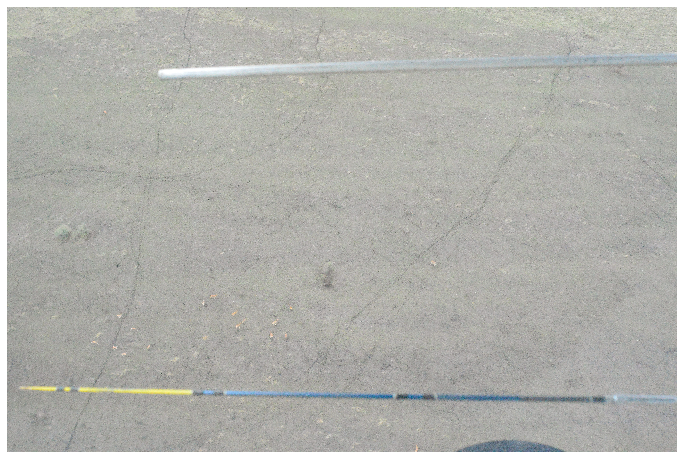

In [79]:
#Look at one large image (but no bboxes)
trainds[0][0].show(figsize = (12,12))

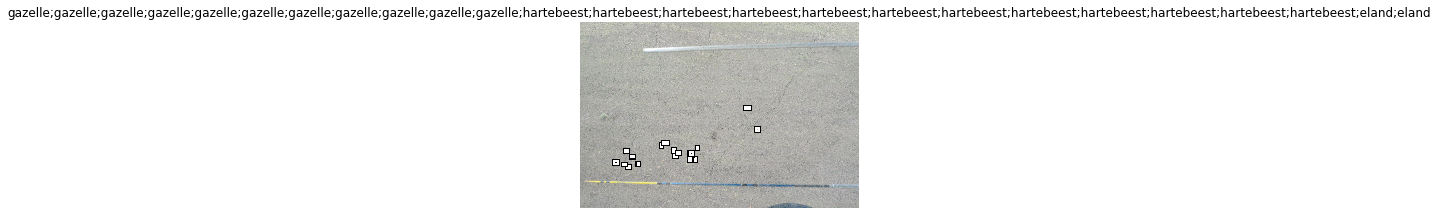

In [82]:
#Another awkward way to look at a single image (annotations on top).  Can't figure out how to make it bigger.

trainds.show(trainds[0])

In [ ]:
#Count boxes per image.  Works but is ridiculously slow -- not sure why
nboxes = 0
[len(trainds[i][1]) for i in range(len(trainds))]

In [ ]:
#show_batch is NOT working; not sure why.  But looking at 1 photo at a time seems to be OK.
dls.show_batch(rows=2, figsize=(12,12))

In [68]:
list(enumerate(dls.vocab))

[(0, '#na#'),
 (1, 'boma'),
 (2, 'buffalo'),
 (3, 'building'),
 (4, 'cow'),
 (5, 'eland'),
 (6, 'elephant'),
 (7, 'gazelle'),
 (8, 'giraffe'),
 (9, 'hartebeest'),
 (10, 'human'),
 (11, 'impala'),
 (12, 'kudu'),
 (13, 'oryx'),
 (14, 'shoats'),
 (15, 'zebra')]

In [ ]:
#Keep: how to get all transforms in two sub-lists into a single flat list
[tfm.__name__ for parts in tfms for tfm in parts]

## Models

In [ ]:
#Example of a pre-made model which I cut manually and then added a few modifications to the head.
def create_new_xresnet50_model():
    m = vision.models.xresnet50() #NOTE: the final parens are necessary!
    #The fucking cut() function didn't work, and neither did create_body(), but this did:
    m_body = nn.Sequential(*list(m.children()))[:8]
    ni = 2048 #the number of blood vessels in the neck (so to speak)
    cnoempty = (dbunch_sm.c - 1) #the number of categories, not including the 'empty' category
    m = nn.Sequential(
        m_body, AdaptiveConcatPool2d(), Flatten(),
        nn.Linear(ni*2, cnoempty))
    #A vector of weights used to create the 'empty' category from the other categories
    m.emptywts = nn.Parameter(torch.zeros(cnoempty)) 
    return m

# HOWARD, THIS IS AS FAR AS I HAVE GOTTEN
* Everything below here is experimental/code scraps.  
*  There's still a question of how to represent empty images (no bboxes) correctly.

In [ ]:
mean,std = [0.5]*3,[0.5]*3
mean,std = broadcast_vec(1, 4, mean, std)
batch_tfms = [IntToFloatTensor, Normalize.from_stats(mean,std)]
tdl = TfmdDL(train_ds, after_batch=batch_tfms, bs=4, device=default_device())

x,y  = tdl.one_batch()
xd,yd = tdl.decode((x,y))


### Add transforms

In [16]:
tfms = None
tfms = get_transforms()

In [17]:
#Keep: how to get all transforms in two sub-lists into a single flat list
[tfm.__name__ for parts in tfms for tfm in parts]

['crop_pad',
 'flip_lr',
 'symmetric_warp',
 'rotate',
 'zoom',
 'brightness',
 'contrast',
 'crop_pad']

## Implement a training cycle

The idea is to cycle through smallish datasets, potentially varying learning rate or augmentation.  One suggestion here was that progressive implementation of different augmentation regimes fared better than actually mixing them concurrently (perhaps too much augmentation if mixed, I'd guess)
- 5 epochs Mixup (it’s the fastest starter), 
- 5 Progressive Sprinkles, 
- 5 CutMix and finished with 
- Ricap (beta=.5 to try and push larger sections).

### A custom ImageSequence class
https://docs.fast.ai/tutorial.itemlist.html

## Functions to create DataFrames, DataBunches, Models, and Learners

#### From-scratch model

#### Prepare learner

### Functions that combine the above

#### New df-->databunch

In [36]:
def get_new_databunch(tr_labels,tr_metadata,sampler,othercol,n_total,imagepath,size,bs,tfms,valid_pct,dbunch_type):
    print('Getting dataframe')
    df = get_df(tr_labels,tr_metadata,sampler,othercol,n_total,imagepath)
    cols = list(df.columns.drop(['file_name','seq_id','datetime']))
    
    if dbunch_type=='ImageSequence':
        print('Getting dbunch')
        dbunch = get_ImageSequence_dbunch(df,imagepath,size,bs,tfms,valid_pct)
    else:
        print('Getting ImageSequence dbunch')
        dbunch = get_databunch(df,imagepath,size,bs,tfms,valid_pct)
    return dbunch

#### New df-->DataBunch-->Learner

In [37]:
def learner_with_data(tr_labels,tr_metadata,imagepath,sampler,othercol,n_total,tfms,valid_pct,dbunch_type,dbunch,learner,shuffle_train_ds,callback_fns,split_fn,freeze_to,size,bs,modelpath,model_to_load): 
    "Loads a learner and creates a new databunch if dbunch is None"
    if(dbunch is None):
        print('Making new databunch')
        dbunch = get_new_databunch(tr_labels,tr_metadata,sampler,othercol,n_total,imagepath,size,bs,tfms,valid_pct,dbunch_type)
    else:
        print(f'Using existing databunch')
    print('preparing learner')
    learner = prepare_learner(learner_source,learner,dbunch,shuffle_train_ds,callback_fns,split_fn,freeze_to,modelpath,model_to_load) #add augmentation changes here
    return learner

#### Train one cycle: new df-->databunch-->Learner-->fit_one_cycle(n_epochs)

In [38]:
def train_cycle(tr_labels,tr_metadata,imagepath,sampler,othercol,n_total,tfms,
                valid_pct,dbunch_type,learner,shuffle_train_ds,callback_fns,split_fn,freeze_to,
                size,bs,n_epochs,lrs,div_factor,tc,modelpath,model_to_load,save_model_as): 
    learner = learner_with_data(tr_labels,tr_metadata,imagepath,sampler,othercol,n_total,tfms,valid_pct,dbunch_type,dbunch,learner_source,learner,shuffle_train_ds,callback_fns,split_fn,freeze_to,size,bs,modelpath,model_to_load)
    print('training')  
    learner.fit_one_cycle(n_epochs,lrs,div_factor=div_factor)
    return learner

# Use the functions

#### Get a new dataframe

In [33]:
othercol = 'empty' 
n_total = 100 #This is the number of sequences: the image count will be ~2.5x higher.  Must be larger than bs.
sampler = random_sample #OR positives_sample, balanced_sample, balanced_sample_halfother
imagepath = Path('/cdata/serengeti')

dfnew = get_df(train_labels,train_metadata,sampler,othercol,n_total,imagepath)

Getting sample
Getting metadata for sample
Getting labels
Dropping images if they can't be found
Dataframe has 277 images; 0 missing files were dropped.
Sorting the dataframe by seq_id, then filename


In [ ]:
il = ImageSequenceList.from_df(df=dfnew,cols=[0,1],path=imagepath)

#### Load and prepare learner and add new databunch

In [ ]:
del learner;
#gc.collect()

In [ ]:
fit_one_cycle??

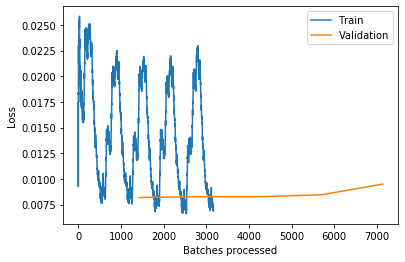

In [115]:
learner.recorder.plot_losses()

In [111]:
# import datetime
# datetime.datetime.now().strftime("%b%d_%H%M")
#print(f'{%m-%d_%H:%M:}'.format( date=datetime.datetime.now() ))

#str(modelpath) + '/seqmodel_' + datetime.datetime.now().strftime("%d%b%H%M_")
save_model_root = str(modelpath) + '/seqmodel_' + datetime.datetime.now().strftime("%d%b%H%M_") #This is given to the SaveModelCallback, below.
save_model_root

'/cdata/serengeti/models/seqmodel_23Jan1311_'

In [90]:
learner.save(modelpath/'seqimg_large_2')

In [91]:
learner.export(modelpath/'seqimg_large_2.pkl')

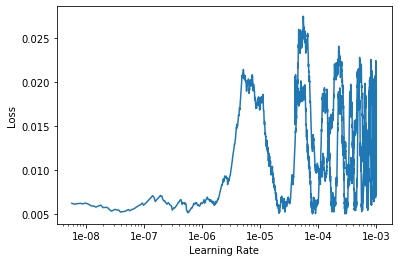

In [88]:
learner.recorder.plot()

In [ ]:
learner.data.classes

In [ ]:
learner.save(modelpath/'seqimg_large_1')

In [ ]:
learner.export(modelpath/'seqimg_large_1export.pkl')

In [ ]:
callbacks = [Recorder(learner),ImageGrouping(learner),
SaveModelCallback(learner,mode='max',every='improvement', monitor='accuracy_thresh', name='seqimg_newest')]
#learner.callbacks = [] #ShowGraph(learner),
learner.callbacks = callbacks


In [ ]:
lr_max=5e-3
lrs = slice(lr_max/50,lr_max/5,lr_max)

learner.fit(5,lrs)

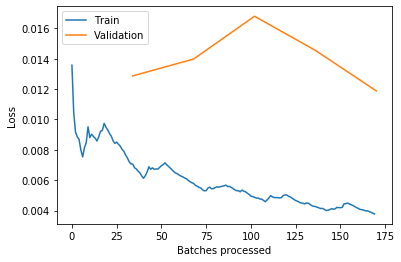

In [43]:
learner.recorder.plot_losses()

### Predict

In [8]:
#NOT USED
#Compile all of the annotation files into a single JSON file.
#This relies on json and glob imports.
# output_list = []
# cnt = 0

# for f in annotation_files:
#     with open(f, "rb") as infile:
#         output_list.append(json.load(infile))
#     print(len(output_list))
# with open("merged_annotations_coco.json", "w") as outfile:
#     json.dump(output_list, outfile)